# Data Cleaning

The purpose of this notebook is to clean unmodifed or modifed csv files collected from ECAAS ODK. 

The notebook contains the following steps:
1. Read in and display an ECAAS ODK csv
2. General Cleaning
3. Clean crop type attributes
5. Construct dictionary for renaming crops
6. Create geometries (working with ODK collected coordinates or working with manually edited coordinates)
9. Export data to geojson and Shapefile


## Load Packages

In [1]:
import os
import geopandas as gpd
import pandas as pd
from shapely.geometry import Polygon

pd.set_option("display.max_columns", None)

from create_geometries import (
    create_geometries_from_manual_edit,
    create_geometries_from_ODK,
)

## Read in ECAAS ODK csv

In [2]:
samples_file = "data/Cleaned_ECAAS_ODK_Datasheet.csv"
samples_df = pd.read_csv(samples_file)

##  Initial inspection

To understand the kind of data available, it is useful to view the first 5 rows, and then view more detailed information

### First five rows of dataframe

In [3]:
samples_df.head()

,data-start,data-end,data-deviceid,data-username,data-welcome,data-organization_name,data-project_name,data-data_consent,data-consent_given-access_consent,data-consent_given-field_fallow,data-consent_given-field_planted-post_harvest_record,data-consent_given-field_planted-post_harvest_tip,data-consent_given-field_planted-primary_crop_type,data-consent_given-field_planted-multiple_crops,data-consent_given-field_planted-multiple_crops_percentage,data-consent_given-field_planted-primary_crop,data-consent_given-field_planted-primary_crop_other,data-consent_given-field_planted-primary_coffee_variety_other,data-consent_given-field_planted-secondary_crop,data-consent_given-field_planted-secondary_crop_other,Cleaned_Coordinates,data-consent_given-field_planted-crop_development,data-consent_given-field_planted-primary_coffee_variety,data-consent_given-field_planted-trees_count,data-consent_given-field_planted-trees_planting_date,data-consent_given-field_planted-yield_reporting,data-consent_given-field_planted-yield_reporting_guide,data-consent_given-field_planted-repeat_tip,data-consent_given-field_planted-tree_rpt,data-consent_given-field_planted-sampling_site_rpt,data-consent_given-field_planted-planting_date_type,data-consent_given-field_planted-planting_date_exact,data-consent_given-field_planted-planting_date_estimate,data-consent_given-field_planted-planting_date,data-consent_given-field_planted-harvesting_date_type,data-consent_given-field_planted-harvesting_date_exact,data-consent_given-field_planted-harvesting_date_estimate,data-consent_given-field_planted-harvesting_date,data-consent_given-water_source,data-consent_given-field_center,data-consent_given-field_center-altitude,data-consent_given-field_center-accuracy,data-consent_given-field_outside_corner,data-consent_given-field_outside_corner-altitude,data-consent_given-field_outside_corner-accuracy,data-consent_given-field_boundary,data-consent_given-field_area_grp-field_area,data-consent_given-field_area_grp-field_area_unit,data-consent_given-field_photo_ask,data-consent_given-field_photo_rpt,data-goodbye,data-meta-instanceID,KEY
0,19/4/2022 11:43,19/4/2022 11:46,collect:mUMX72Oc17QENs4a,RCMRD 2,,RCMRD,Zambia crop type mapping,farmer,yes,no,no,,annual,no,,maize,,,,,"-14.987923,28.269215",harvest_ready,,,,no,,,data-consent_given-field_planted-tree_rpt,data-consent_given-field_planted-sampling_site...,unknown,,,,unknown,,,,rainfed,"-14.988505,28.2688773",1155.51,1.892,"-14.988505,28.2688773",,,-14.9884313 28.2688411 0.0 0.0; -14.9878824091...,3.0,acre,yes,data-consent_given-field_photo_rpt,,uuid:5ba13c70-3535-485f-94fe-20f10fcbf0cc,uuid:5ba13c70-3535-485f-94fe-20f10fcbf0cc
1,19/4/2022 11:46,19/4/2022 11:47,collect:mUMX72Oc17QENs4a,RCMRD 2,,RCMRD,Zambia crop type mapping,farmer,yes,no,no,,annual,no,,other_annual,Sweet potato,,,,"-14.987863,28.268245",,,,,no,,,data-consent_given-field_planted-tree_rpt,data-consent_given-field_planted-sampling_site...,unknown,,,,unknown,,,,rainfed,"-14.9877077,28.2684144",997.438,4.134,"-14.9877077,28.2684144",,,-14.987485667735498 28.26893236488104 0.0 0.0;...,2.0,acre,yes,data-consent_given-field_photo_rpt,,uuid:2c74930a-e5a7-4e22-a714-af8087dfff36,uuid:2c74930a-e5a7-4e22-a714-af8087dfff36
2,19/4/2022 11:25,19/4/2022 11:27,collect:mUMX72Oc17QENs4a,RCMRD 2,,RCMRD,Zambia crop type mapping,farmer,yes,no,no,,annual,no,,groundnut,,,,,"-14.987237,28.2651773",,,,,no,,,data-consent_given-field_planted-tree_rpt,data-consent_given-field_planted-sampling_site...,month_year,,1/12/2021,2021-12-01T00:00:00.000+02:00,month_year,,1/4/2022,2022-04-01T00:00:00.000+02:00,rainfed,"-14.987237,28.2651773",1165.201,2.926,"-14.987237,28.2651773",,,-14.987284543864616 28.265905156731606 0.0 0.0...,1.0,hectare,yes,data-consent_given-field_photo_rpt,,uuid:500d004e-57f6-4ae9-adfd-4c3b7aa4837b,uuid:500d004e-57f6-4ae9-adfd-4c3b7aa4837b
3,19/4/2022 10:51,19/4/2022 10:54,collect:mUMX72Oc17QENs4a,RCMRD 2,,RCMRD,Zambia crop type mapping,farmer,yes,no,no,,annual,no,,soybean,,,,

### Display column names, non-null count and dtype

In [4]:
samples_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1059 entries, 0 to 1058
Data columns (total 53 columns):
 #   Column                                                         Non-Null Count  Dtype  
---  ------                                                         --------------  -----  
 0   data-start                                                     1059 non-null   object 
 1   data-end                                                       1059 non-null   object 
 2   data-deviceid                                                  1059 non-null   object 
 3   data-username                                                  1059 non-null   object 
 4   data-welcome                                                   1059 non-null   object 
 5   data-organization_name                                         1059 non-null   object 
 6   data-project_name                                              1059 non-null   object 
 7   data-data_consent                                           

## General Cleaning

* Remove unnecessary prefixes from columns to improve readability
* Convert missing values from " " (single space) to None
* Convert start and end times from object to datetime

In [5]:
# Remove prefixes from columns to improve readability
updated_columns = samples_df.columns.str.replace("data-", "")
updated_columns = updated_columns.str.replace("consent_given-", "")
updated_columns = updated_columns.str.replace("field_planted-", "")

samples_df.columns = updated_columns

In [6]:
# Convert from missing values being " " to None
samples_df = samples_df.replace({" ": None})

In [7]:
# Convert date columns to date strings. Must be string format for shapefile
samples_df["start"] = pd.to_datetime(samples_df["start"], dayfirst=True).dt.strftime("%Y-%m-%d")
samples_df["end"] = pd.to_datetime(samples_df["end"], dayfirst=True).dt.strftime("%Y-%m-%d")

### Display column names, non-null count and dtype after cleaning

In [8]:
samples_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1059 entries, 0 to 1058
Data columns (total 53 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   start                           1059 non-null   object 
 1   end                             1059 non-null   object 
 2   deviceid                        1059 non-null   object 
 3   username                        1059 non-null   object 
 4   welcome                         0 non-null      object 
 5   organization_name               1059 non-null   object 
 6   project_name                    1059 non-null   object 
 7   data_consent                    1059 non-null   object 
 8   access_consent                  1059 non-null   object 
 9   field_fallow                    1059 non-null   object 
 10  post_harvest_record             1059 non-null   object 
 11  post_harvest_tip                0 non-null      object 
 12  primary_crop_type               10

## Clean crop type attributes

The crop name of the primary crop is stored in the `primary_crop` field if selected from the toolkit list, and the `primary_crop_other` field otherwise. The same is true of the `secondary_crop` and `secondary_crop_other` columns. The following steps are used to produce single unified `primary_crop` and `secondary_crop` fields:

For each pair, the following steps are run:

1. Identify all rows containing a valid entry in the `crop_other` field.
2. Convert these entries to lower case to match entries in the `crop` field.
3. Copy valid entries from the `crop_other` field to the `crop` field.
4. Drop the `crop_other` field.

In [9]:
prefixes = ["primary", "secondary"]

for prefix in prefixes:
    
    other_crop_condition = samples_df.loc[:, f"{prefix}_crop_other"].notna()
    
    samples_df.loc[other_crop_condition, f"{prefix}_crop"] = samples_df.loc[other_crop_condition, f"{prefix}_crop_other"].str.lower()
    
    samples_df = samples_df.drop(f"{prefix}_crop_other", axis="columns")

### View unique crops and value counts

Now that all crops have been collated into a single column and format, running `value_counts` will display the unique spellings and counts. After viewing this, you will need to compile a dictionary to coerce varied spellings for the same crop into a single spelling.

In [10]:
# Get value counts for all instances in each crop column
for prefix in prefixes:
    
    print(samples_df[[f"{prefix}_crop"]].value_counts(
        dropna=False
    ).sort_index(ascending=True))

    print("---------")

primary_crop    
banana                4
bananas               1
beans                28
cassava              39
cotton               20
cowpeas               3
eggplant              2
groundnut            22
groundnuts            1
irish potatoes        2
macadamia             1
macadamia nut         1
macadamia nuts        1
maize               546
millet               11
napier grass          1
ochra                 3
ochra vegetables      1
pumpkin               2
rice                  1
ripe vegetables       1
sorghum              20
soybean             212
sugarcane             1
sunflower            76
sweet potato         26
sweet potatoes       20
tobacco               6
tomatoes              3
vegetables            2
water melon           1
watermelon            1
dtype: int64
---------
secondary_crop        
beans                       2
cassava                     2
cassava, sweet potato       1
cotton                      2
groundnut                   8
maize              

### Construct dictionary for renaming crops

Based on the values in the list above, we compiled the following dictionary, then applied it to the `primary_crop` and `secondary_crop` fields. This step will rename appearances of the dictionary key to the corresponding value. For example "bananas" will become "banana".

After running the next two cells, review the cleaned crop list to check if any additions need to be made to the dictionary. Repeat as needed.

In [11]:
# Create a dictionary to clean any remaining mismatched data
crop_dictionary = {
    "bananas": "banana",
    "groundnuts": "groundnut",
    "macadamia nuts": "macadamia",
    "macadamia nut": "macadamia",
    "ochra vegetables": "ochra",
    "okra": "ochra",
    "soyabean": "soyabean",
    "sweet potatoes": "sweet potato",
    "water melon": "watermelon",
}

In [12]:
# Apply the dictionary to the crop columns
for prefix in prefixes:
    samples_df.loc[:, f"{prefix}_crop"] = samples_df.loc[:, f"{prefix}_crop"].replace(
        crop_dictionary
    )

    print(samples_df[f"{prefix}_crop"].value_counts())
    print("---------")

maize              546
soybean            212
sunflower           76
sweet potato        46
cassava             39
beans               28
groundnut           23
sorghum             20
cotton              20
millet              11
tobacco              6
banana               5
ochra                4
cowpeas              3
macadamia            3
tomatoes             3
irish potatoes       2
watermelon           2
vegetables           2
eggplant             2
pumpkin              2
sugarcane            1
rice                 1
napier grass         1
ripe vegetables      1
Name: primary_crop, dtype: int64
---------
sunflower                 40
maize                     29
soybean                   14
sweet potato              10
groundnut                  8
sorghum                    6
pumpkin                    3
cassava                    2
ochra                      2
cotton                     2
beans                      2
soyabean                   1
cassava, sweet potato      1
sweet

Text(0.5, 1.0, 'Crops with fewer than 10 samples')

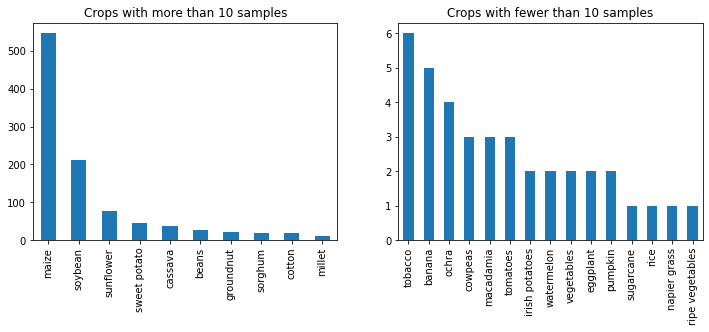

In [13]:
import matplotlib.pyplot as plt

counts = samples_df['primary_crop'].value_counts()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

counts[counts >= 10].plot(kind='bar', ax=axes[0])
counts[counts < 10].plot(kind='bar', ax=axes[1])
axes[0].set_title("Crops with more than 10 samples")
axes[1].set_title("Crops with fewer than 10 samples")

## Create geometries

This section converts geometries collected by the ECAAS ODK toolkit from strings to Shapely geomerties for use with the Open Data Cube. It can process:
* A csv produced from the ECAAS ODK toolkit
* A modified version of the csv from the ECAAS ODK toolkit

---

### Working with ODK collected coordinates

The following logic is used to extract point and polygon geometries from the ODK output:

- If `access_consent == "yes"`, then row should have field boundary and field center
    - centre point is given as a "lat,lon" point
    - boundary is given as "lat lon alt acc; lat lon alt acc;" for each point collected along the boundary, separated by semi-colons
- If `access_consent == "no"`, then row should only have field outside corner (no boundary)
    - outer corner point is given as a "lat,lon"
    
For points, the method creates a new `point_location` location field, with values of either "center" or "outside corner".

---

### Working with manually edited coordinates

Specifically, after collecting points using the ECAAS ODK toolkit, an analyst may wish to manually update the points, for example, moving them from the road to within the field. If they have provided these as a new `lat,lon` pair in a new column of the csv, these points may be used instead of the original ODK points. 

Different cleaning routines will be run depending on the type of file supplied. The user may dictate which process to use by specifying the variable `cleaned_geom_column` as:
* `None` for an unmodified file (uses ODK collected coordinates)
* `"column_name"` for a modified file -- where `column_name` contains the modified lat,lon values in the csv (uses modified coordinates).

If using modified coordinates, the `point_location` field will be given as "manual"

In [14]:
# use with original ODK toolkit output
# cleaned_geom_column = None

# use with modified ODK toolkit output. The column listed below must contain data in lat,lon format (i.e. -14.4,28.0)
cleaned_geom_column = "Cleaned_Coordinates"

In [15]:
if cleaned_geom_column is None:
    # Return cleaned samples from ECAAS ODK format, containing mix of points and polygons
    cleaned_samples_df = create_geometries_from_ODK(samples_df)

    # Create two geodataframes, one with point geometry and one with polygon geometry
    points_gdf = cleaned_samples_df.drop(["field_boundary_polygon"], axis="columns").copy()
    polygons_gdf = cleaned_samples_df.set_geometry("field_boundary_polygon", drop=True).copy()
    polygons_gdf = polygons_gdf.loc[
        ~cleaned_samples_df["field_boundary_polygon"].isna(), :
    ]

else:
    # Retun geodataframe containing point geometry, extracted from cleaned_geom_column
    points_gdf = create_geometries_from_manual_edit(samples_df, cleaned_geom_column)
    polygons_gdf = None

## Export data to geojson and Shapefile

For the final output, we will export all points and polygons, as well as the cleaned single crop file. The cleaned single crop file will be used for the remainder of the machine learning training.

We define a dictionary for the column names to be shortened to when writing to the Shapefile format (10 character limit).

In [16]:
# Create dictionary with columns of interest and corresponding 10-character names
col_rename_dict = {
    "start": "start",
    "end": "end",
    "field_fallow": "fallow",
    "primary_crop_type": "pri_type",
    "primary_crop": "pri_crop",
    "crop_development": "crop_dev",
    "multiple_crops": "multi_crop",
    "multiple_crops_percentage": "multi_per",
    "secondary_crop": "sec_crop",
    "geometry": "geometry",
}

# Create results directory if it doesn't exist
if not os.path.exists("results"):
    os.makedirs("results")
    
# Export polygons
if polygons_gdf is not None:

    polygons_gdf[col_rename_dict.keys()].to_file("results/cleaned_polygons.geojson")
    polygons_gdf[col_rename_dict.keys()].rename(columns=col_rename_dict).to_file(
        "results/cleaned_polygons.shp"
    )

# Add additional column to specify the point location
col_rename_dict["point_location"] = "point_loc"

# Export points
points_gdf[col_rename_dict.keys()].to_file("results/cleaned_points.geojson")
points_gdf[col_rename_dict.keys()].rename(columns=col_rename_dict).to_file(
    "results/cleaned_points.shp"
)